In [42]:
import glob 
import numpy as np
import networkx as nx
from collections import defaultdict
from cdlib import algorithms
import matplotlib.pyplot as plt
from cdlib.evaluation import modularity_overlap as modularity

from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, f1_score, accuracy_score
from collections import Counter
import pickle
import json
import os


In [2]:
# final kmatrix
with open('/Users/arjuns/Downloads/code_res_paper/paper-results-code/weisfeilerlehman/final_kernel_matrix/complete_kernel_matrix_v2.pkl', 'rb') as f:
    kmatrix = pickle.load(f)

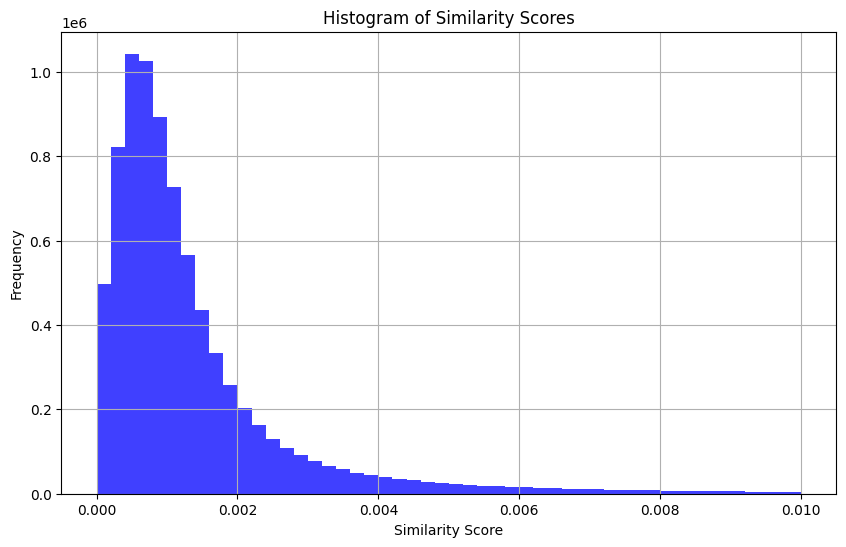

In [3]:
similarity_matrix = np.array(kmatrix)
similarity_matrix = (similarity_matrix + similarity_matrix.T) / 2

np.fill_diagonal(similarity_matrix, 0) # Remove self-similarities

# Flatten the matrix and remove zero values (self-similarities already removed)
similarity_scores = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]

plt.figure(figsize=(10, 6))
plt.hist(similarity_scores, bins=50, alpha=0.75, color='blue', range=(0, 0.01))
plt.title('Histogram of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [4]:
bp = "/Users/arjuns/Downloads/notebooks_v2/v2/graphs"
list_of_files = glob.glob(f'{bp}/*/*.graphml')

files_with_no_nodes = [
    f'{bp}/Technology/learnmachinelearning.json.graphml',
    f'{bp}/Technology/DataHoarder.json.graphml',
    f'{bp}/Technology/talesfromtechsupport.json.graphml',
    f'{bp}/Technology/technews.json.graphml',
    f'{bp}/Technology/apolloapp.json.graphml',
    f'{bp}/Technology/ipad.json.graphml',
    f'{bp}/Technology/onions.json.graphml',
    f'{bp}/Technology/Windows10.json.graphml',
    f'{bp}/Art/AnalogCommunity.json.graphml',
    f'{bp}/Art/iWallpaper.json.graphml',
    f'{bp}/Art/ImaginaryHorrors.json.graphml',
    f'{bp}/Art/pic.json.graphml',
    f'{bp}/Art/ArtHistory.json.graphml',
    f'{bp}/Art/80s.json.graphml',
    f'{bp}/Art/Pyrography.json.graphml',
    f'{bp}/Art/blenderhelp.json.graphml',
    f'{bp}/Art/MobileWallpaper.json.graphml',
    f'{bp}/Art/wallpaperengine.json.graphml'
]
# Remove files with no nodes
list_of_files = [file for file in list_of_files if file not in files_with_no_nodes]

In [5]:
with open('./inflection_points.pkl', 'rb') as f:
    inflection_points = pickle.load(f)

In [6]:
inflection_points

array([2.00200200e-05, 1.46146146e-03, 3.61361361e-03, 4.19419419e-03,
       4.82482482e-03, 5.20520521e-03, 5.49549550e-03, 5.99599600e-03,
       6.66666667e-03, 7.41741742e-03, 7.78778779e-03, 8.12812813e-03,
       8.55855856e-03, 9.21921922e-03, 9.65965966e-03, 4.80480480e-04,
       3.51351351e-03, 4.02402402e-03, 4.45445445e-03, 5.04504505e-03,
       5.33533534e-03, 5.73573574e-03, 6.28628629e-03, 7.17717718e-03,
       7.58758759e-03, 8.00800801e-03, 8.30830831e-03, 8.94894895e-03,
       9.42942943e-03, 9.89989990e-03, 4.76995214e-03, 4.00000000e-03])

In [7]:
inflection_points = [x for x in inflection_points if x not in [2.002002002002002e-05, 0.00048048048048048047, 0.0014614614614614613, 0.004]]

In [8]:
def name_processing(name):
    aux = name.split("/")
    return aux[-2] + "/" , aux[-1].split(".")[0]

graphs = {}
for threshold in inflection_points:
    print(f"Processing threshold: {threshold}")
    G = nx.Graph()

    for graph in list_of_files:
        topic, subreddit = name_processing(graph)
        G.add_node(graph)
        G.nodes[graph]['topic'] = topic
        G.nodes[graph]['subreddit'] = subreddit

    for i in range(len(similarity_matrix)):
        for j in range(i + 1, len(similarity_matrix)):
            if similarity_matrix[i][j] > threshold:
                G.add_edge(list_of_files[i], list_of_files[j], weight=similarity_matrix[i][j])

    graphs[threshold] = G


Processing threshold: 0.0036136136136136134
Processing threshold: 0.004194194194194194
Processing threshold: 0.004824824824824825
Processing threshold: 0.005205205205205205
Processing threshold: 0.005495495495495496
Processing threshold: 0.005995995995995996
Processing threshold: 0.006666666666666666
Processing threshold: 0.007417417417417417
Processing threshold: 0.007787787787787787
Processing threshold: 0.008128128128128128
Processing threshold: 0.008558558558558558
Processing threshold: 0.009219219219219218
Processing threshold: 0.00965965965965966
Processing threshold: 0.0035135135135135136
Processing threshold: 0.004024024024024024
Processing threshold: 0.004454454454454454
Processing threshold: 0.005045045045045045
Processing threshold: 0.005335335335335335
Processing threshold: 0.005735735735735736
Processing threshold: 0.006286286286286286
Processing threshold: 0.007177177177177177
Processing threshold: 0.007587587587587588
Processing threshold: 0.008008008008008008
Processing

In [9]:
# do a sanity check on whether all graph nodes attributes are non -empty
for threshold, G in graphs.items():
    for node in G.nodes:
        if G.nodes[node] == {}:
            print(f"Empty node found in graph with threshold {threshold}")
            break
    print(f"Graph with threshold {threshold} is ok")

Graph with threshold 0.0036136136136136134 is ok
Graph with threshold 0.004194194194194194 is ok
Graph with threshold 0.004824824824824825 is ok
Graph with threshold 0.005205205205205205 is ok
Graph with threshold 0.005495495495495496 is ok
Graph with threshold 0.005995995995995996 is ok
Graph with threshold 0.006666666666666666 is ok
Graph with threshold 0.007417417417417417 is ok
Graph with threshold 0.007787787787787787 is ok
Graph with threshold 0.008128128128128128 is ok
Graph with threshold 0.008558558558558558 is ok
Graph with threshold 0.009219219219219218 is ok
Graph with threshold 0.00965965965965966 is ok
Graph with threshold 0.0035135135135135136 is ok
Graph with threshold 0.004024024024024024 is ok
Graph with threshold 0.004454454454454454 is ok
Graph with threshold 0.005045045045045045 is ok
Graph with threshold 0.005335335335335335 is ok
Graph with threshold 0.005735735735735736 is ok
Graph with threshold 0.006286286286286286 is ok
Graph with threshold 0.0071771771771771

In [11]:
true_categories = {
    list_of_files[i].split("/")[-1].split(".")[0] : list_of_files[i].split("/")[-2] for i in range(len(list_of_files))
}
true_categories

{'teenagersbuthot': 'Internet Culture and Memes',
 'AsbestosRemovalMemes': 'Internet Culture and Memes',
 'sadlygokarts': 'Internet Culture and Memes',
 'peopleofwalmart': 'Internet Culture and Memes',
 'ani_bm': 'Internet Culture and Memes',
 'memesopdidnotlike': 'Internet Culture and Memes',
 'LTB_iel': 'Internet Culture and Memes',
 'MAAU': 'Internet Culture and Memes',
 'oddlymesmerizing': 'Internet Culture and Memes',
 'schizoposters': 'Internet Culture and Memes',
 'okbuddyphd': 'Internet Culture and Memes',
 'FindTheSniper': 'Internet Culture and Memes',
 'AllThatIsInteresting': 'Internet Culture and Memes',
 'VeryExpensive': 'Internet Culture and Memes',
 'whereintheworld': 'Internet Culture and Memes',
 'antimeme': 'Internet Culture and Memes',
 'Indiangirlsontinder': 'Internet Culture and Memes',
 'BLAHAJ': 'Internet Culture and Memes',
 'Daniellarson': 'Internet Culture and Memes',
 'evilbuildings': 'Internet Culture and Memes',
 'xkcd': 'Internet Culture and Memes',
 'ThatP

In [12]:
def get_homogeneity_scores(partition_dict):
    # Tracking node assignments across communities to identify overlaps
    node_assignments = defaultdict(list)
    for community_id, subreddits in partition_dict.items():
        for subreddit in subreddits:
            node = subreddit.split("/")[-1]  # Extract the node identifier
            node_assignments[node].append(community_id)
    
    # Compute the most common category for each community
    most_common_category_dict = {}
    for community_id, subreddits in partition_dict.items():
        categories = [true_categories[subreddit.split("/")[-1].split(".")[0]] for subreddit in subreddits if subreddit.split("/")[-1].split(".")[0] in true_categories]
        category_counts = Counter(categories)
        if category_counts:
            most_common_category, _ = category_counts.most_common(1)[0]
            most_common_category_dict[community_id] = most_common_category
        else:
            most_common_category_dict[community_id] = None  # No valid category found

    # Calculate the homogeneity for each community using weighted contributions
    homogeneity_scores = {}
    for community_id, subreddits in partition_dict.items():
        categories = []
        weights = []
        for subreddit in subreddits:
            node = subreddit.split("/")[-1]
            if node in true_categories:
                category = true_categories[node]
                categories.append(category)
                # Weight inversely proportional to correct community assignments
                if category == most_common_category_dict[community_id]:
                    correct_assignments = [cid for cid in node_assignments[node] if true_categories[node] == most_common_category_dict[cid]]
                    weights.append(1 / len(correct_assignments) if correct_assignments else 1)
                else:
                    weights.append(1)
        
        category_counts = Counter(categories)
        if category_counts:
            most_common_category, _ = category_counts.most_common(1)[0]
            weighted_counts = sum(w for cat, w in zip(categories, weights) if cat == most_common_category)
            homogeneity = weighted_counts / sum(weights) if sum(weights) > 0 else 0
        else:
            homogeneity = 0
        
        homogeneity_scores[community_id] = homogeneity
    
     # Calculate mean and median homogeneity
    mean_homogeneity = np.mean(list(homogeneity_scores.values())) if homogeneity_scores else 0
    median_homogeneity = np.median(list(homogeneity_scores.values())) if homogeneity_scores else 0
    
    return mean_homogeneity, median_homogeneity


In [43]:
def calculate_community_metrics(partition_dict):
    y_true = []
    y_pred = []

    node_assignments = defaultdict(list)
    for comm_id, subreddits in partition_dict.items():
        for subreddit in subreddits:
            node = subreddit.split("/")[-1]  # Extract the node identifier
            node_assignments[node].append(comm_id)

    most_common_category_dict = {}
    for community_id, subreddits in partition_dict.items():
        categories = [true_categories[subreddit.split("/")[-1].split(".")[0]] for subreddit in subreddits if subreddit.split("/")[-1].split(".")[0] in true_categories]
        category_counts = Counter(categories)
        if category_counts:
            most_common_category, _ = category_counts.most_common(1)[0]
            most_common_category_dict[community_id] = most_common_category
        else:
            most_common_category_dict[community_id] = None 
        
    y_true, y_pred = [], []
    
    for node, comm_ids in node_assignments.items():
        if node in true_categories:
            true_label = true_categories[node]
            pred_labels = [most_common_category_dict[comm_id] for comm_id in comm_ids if most_common_category_dict[comm_id] is not None]
            
            if pred_labels:
                most_common_pred_label = Counter(pred_labels).most_common(1)[0][0]
                y_true.append(true_label)
                y_pred.append(most_common_pred_label)

    # Compute metrics
    f1 = f1_score(y_true, y_pred, average='macro')  # Macro F1 for multi-class
    nmi = normalized_mutual_info_score(y_true, y_pred)
    ari = adjusted_rand_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    return f1, nmi, ari, acc

In [14]:
def remove_single_node_communities(partition):
    temp = {k: v for k, v in partition.items() if len(v) > 1}
    return temp, partition

In [15]:
def validate_partition(G, partition):
    """ Ensure every node is covered exactly once in the partition. """
    all_nodes = set(G.nodes())
    covered_nodes = set()
    for community in partition:
        if not community:  # Skip empty communities if any
            continue
        community_set = set(community)
        if not covered_nodes.isdisjoint(community_set):
            raise ValueError("Overlap detected in communities")
        covered_nodes.update(community_set)

    if covered_nodes != all_nodes:
        raise ValueError("Partition does not cover all nodes")

In [ ]:
metrics = defaultdict(lambda: defaultdict(dict))

In [44]:
import logging
from collections import defaultdict

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def angel(G, threshold=0.9):
    communities = algorithms.angel(G, threshold=threshold)
    return {i: [com.split("/")[-1].split(".")[0] for com in comm] for i, comm in enumerate(communities.communities)}, communities

def demon(G, epsilon=0.6):
    communities = algorithms.demon(G, epsilon=epsilon)
    return {i: [com.split("/")[-1].split(".")[0] for com in comm] for i, comm in enumerate(communities.communities)}, communities

def core_expansion(G):
    communities = algorithms.core_expansion(G)
    return {i: [com.split("/")[-1].split(".")[0] for com in comm] for i, comm in enumerate(communities.communities)}, communities

def slpa(G, r=0.1):
    communities = algorithms.slpa(G, r=r)
    return {i: [com.split("/")[-1].split(".")[0] for com in comm] for i, comm in enumerate(communities.communities)}, communities

def multicom(G):
    communities = algorithms.multicom(G, seed_node=0)
    return {i: [com.split("/")[-1].split(".")[0] for com in comm] for i, comm in enumerate(communities.communities)}, communities

algorithms_list = [angel, demon, core_expansion, slpa, multicom]


for threshold, graph in graphs.items():
    if threshold in [0.004, 0.0036136136136136134]:
        continue
    for algorithm in algorithms_list:
        if not os.path.exists(f"./overlapping_communities/{algorithm.__name__}_{threshold}communities.json"):
            logger.info(f"Running {algorithm.__name__} for threshold {threshold}")
            partition, comm = algorithm(graph)
            partition, original = remove_single_node_communities(partition)

            if len(partition) <= 1:
                logger.warning(f"Skipping {algorithm.__name__} for threshold {threshold}: partition has 1 or fewer communities")
                continue

            with open(f'./overlapping_communities/{algorithm.__name__}_{threshold}communities.json', 'w') as f:
                json.dump(partition, f)
            mean_homogeneity, median_homogeneity = get_homogeneity_scores(partition)
            mod = modularity(graph, comm)
            metrics[algorithm.__name__][threshold]["modularity"] = mod
            metrics[algorithm.__name__][threshold]["mean_homogeneity"] = mean_homogeneity
            metrics[algorithm.__name__][threshold]["median_homogeneity"] = median_homogeneity
            logger.info(f"Metrics calculated for {algorithm.__name__} at threshold {threshold}")
            logger.info(f"Modularity: {modularity}, Mean Homogeneity: {mean_homogeneity}, Median Homogeneity: {median_homogeneity}")

        else:
            logger.info(f"Already processed {algorithm.__name__} for {threshold}, just recomputing some metrics.")
            try:
                partition = json.load(open(f"./overlapping_communities/{algorithm.__name__}_{threshold}communities.json", "r"))
            except:
                continue
        
        f1, nmi, ari, acc = calculate_community_metrics(partition)
        metrics[algorithm.__name__][threshold]["nmi"] = nmi
        metrics[algorithm.__name__][threshold]["ari"] = ari
        metrics[algorithm.__name__][threshold]["f1"] = f1
        metrics[algorithm.__name__][threshold]['acc'] = acc
        logger.info(f"NMI: {nmi}, ARI: {ari}, F1: {f1}, Acc: {acc}")

logger.info("Processing completed for all algorithms and thresholds.")


2025-02-23 16:57:35,451 - INFO - Already processed angel for 0.004194194194194194, just recomputing some metrics.
2025-02-23 16:57:35,597 - INFO - NMI: 0.01219743569555106, ARI: -4.290976709556316e-05, F1: 0.031254326430242035, Acc: 0.15547169811320755
2025-02-23 16:57:35,597 - INFO - Already processed demon for 0.004194194194194194, just recomputing some metrics.
2025-02-23 16:57:35,718 - INFO - NMI: 0.009886067295023698, ARI: -4.11913694710822e-05, F1: 0.028249471191635324, Acc: 0.15321169707573107
2025-02-23 16:57:35,719 - INFO - Already processed core_expansion for 0.004194194194194194, just recomputing some metrics.
2025-02-23 16:57:35,913 - INFO - NMI: 0.45697203247397256, ARI: 0.20427814015720663, F1: 0.5275921840541408, Acc: 0.5521472392638037
2025-02-23 16:57:35,914 - INFO - Running slpa for threshold 0.004194194194194194
2025-02-23 16:58:48,550 - WARNING - Skipping slpa for threshold 0.004194194194194194: partition has 1 or fewer communities
2025-02-23 16:58:48,552 - INFO - R

In [45]:
metrics

defaultdict(<function __main__.<lambda>()>,
            {'angel': defaultdict(dict,
                         {0.0036136136136136134: {'modularity': FitnessResult(min=None, max=None, score=0.02987971915109344, std=None),
                           'mean_homogeneity': 0.5497619399879039,
                           'median_homogeneity': 0.5876623376623377,
                           'nmi': 0.011899489483897302,
                           'ari': -0.0005623365562923312,
                           'f1': 0.02912084999685784,
                           'acc': 0.15481793410948724},
                          0.004194194194194194: {'modularity': FitnessResult(min=None, max=None, score=0.002751792858349391, std=None),
                           'mean_homogeneity': 0.6331421311328761,
                           'median_homogeneity': 0.75,
                           'nmi': 0.01219743569555106,
                           'ari': -4.290976709556316e-05,
                           'f1': 0.03125432643024

In [48]:
def merge_and_save_json(dict1, dict2, output_filename):
    merged_dict = {**dict1, **dict2}  # Merge dictionaries
    with open(output_filename, "w", encoding="utf-8") as f:
        json.dump(merged_dict, f, indent=4)  # Save as JSON with formatting

merge_and_save_json(metrics, {}, "./metrics/ocd_metrics.json")

In [49]:
metrics = json.load(open('./metrics/ocd_metrics.json', 'r'))

In [57]:
metrics

{'angel': {'0.0036136136136136134': {'modularity': [None,
    None,
    0.02987971915109344,
    None],
   'mean_homogeneity': 0.5497619399879039,
   'median_homogeneity': 0.5876623376623377,
   'nmi': 0.011899489483897302,
   'ari': -0.0005623365562923312,
   'f1': 0.02912084999685784,
   'acc': 0.15481793410948724},
  '0.004194194194194194': {'modularity': [None,
    None,
    0.002751792858349391,
    None],
   'mean_homogeneity': 0.6331421311328761,
   'median_homogeneity': 0.75,
   'nmi': 0.01219743569555106,
   'ari': -4.290976709556316e-05,
   'f1': 0.031254326430242035,
   'acc': 0.15547169811320755},
  '0.004824824824824825': {'modularity': [None,
    None,
    -0.046602191425017696,
    None],
   'mean_homogeneity': 0.4242050934015163,
   'median_homogeneity': 0.38650306748466257,
   'nmi': 0.03357066451010256,
   'ari': 0.0017843916379074638,
   'f1': 0.05755020068899641,
   'acc': 0.1714939024390244},
  '0.005205205205205205': {'modularity': [None,
    None,
    -0.02897210

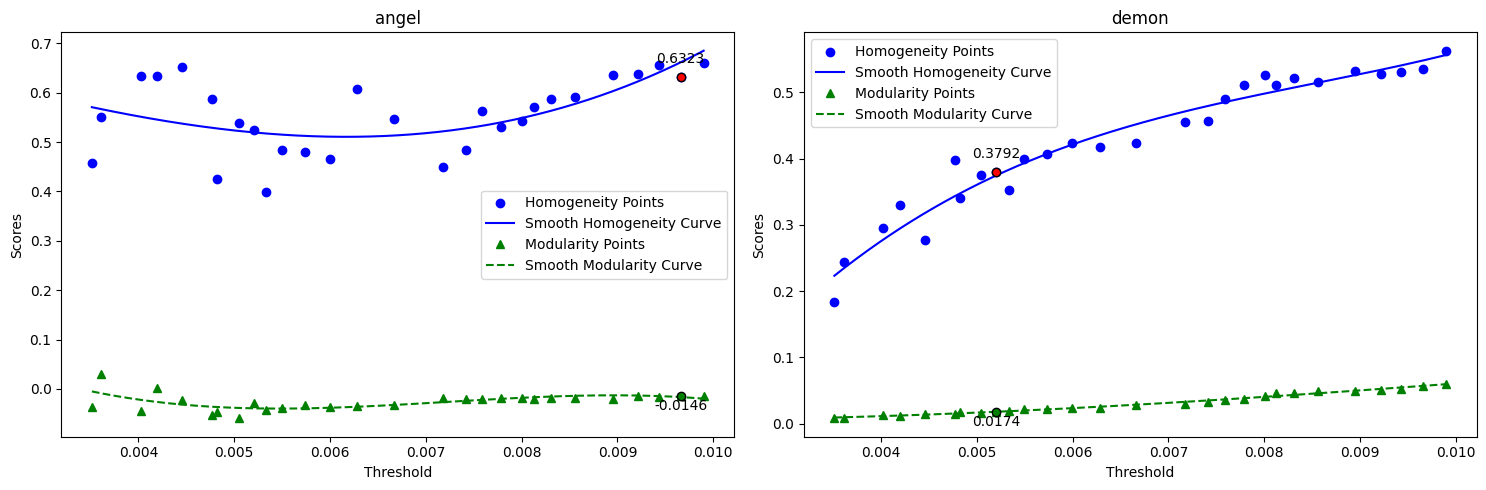

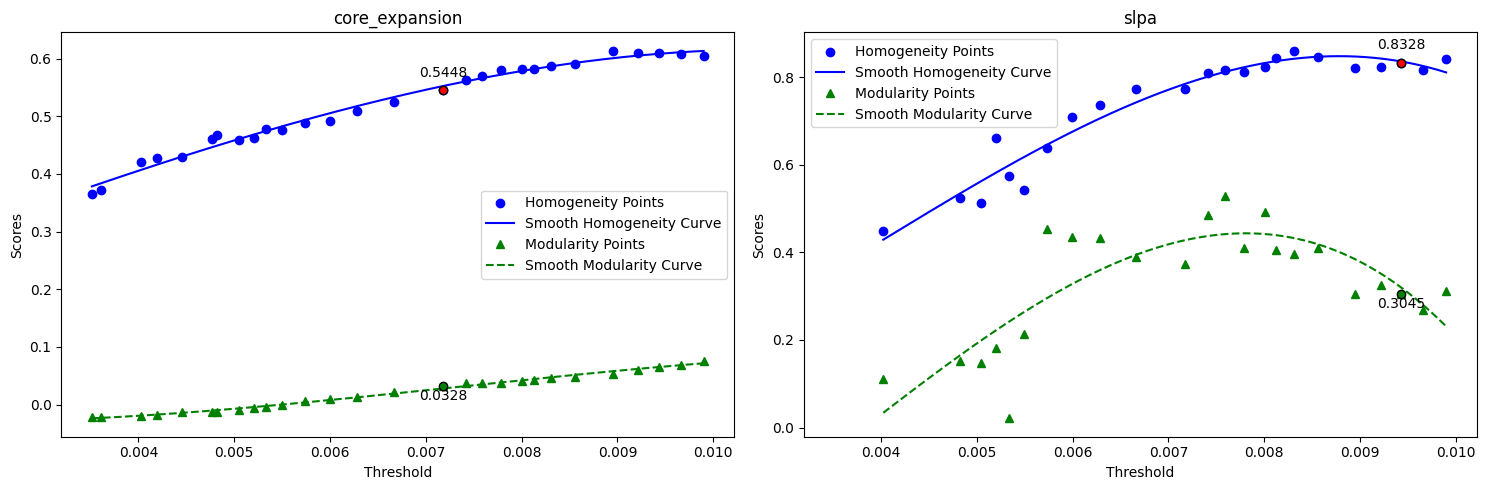

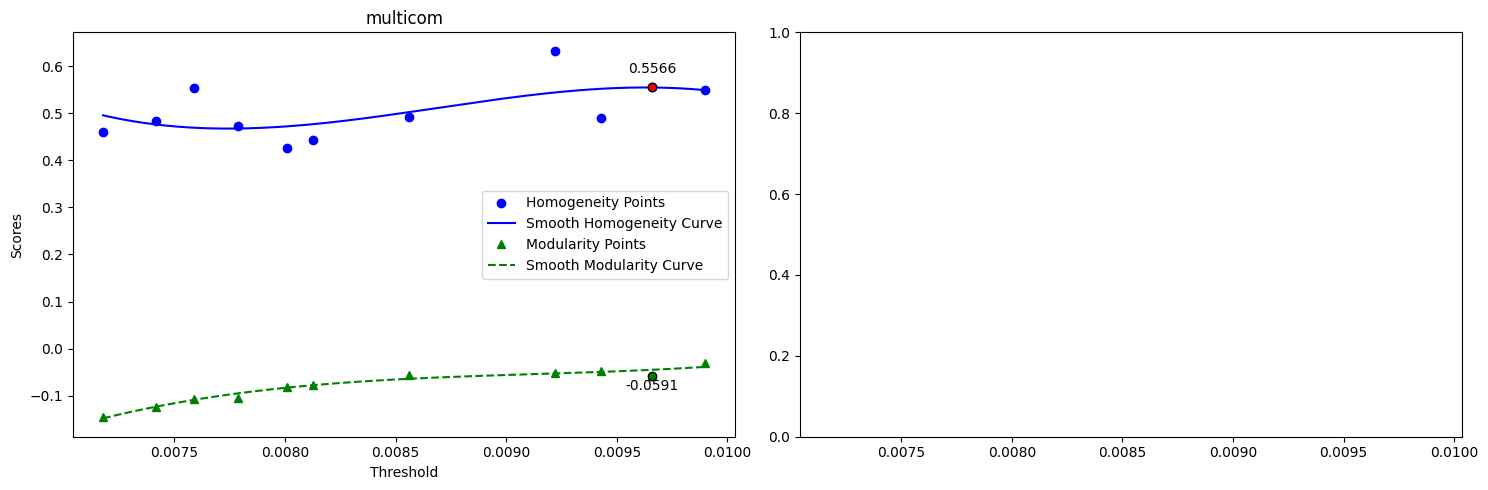

In [58]:
def plot(data, algorithms, target_threshold=[]):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharex=True, sharey=False)
    axes = axes.flatten()  # Flatten the array of axes for easier iteration

    algorithms = [algo.__name__ if callable(algo) else algo for algo in algorithms]

    for idx, algo in enumerate(algorithms):
        thresholds = np.array(list(data[algo].keys()), dtype=float)
        homogeneities = np.array([data[algo][str(threshold)]['mean_homogeneity'] for threshold in thresholds])
        modularities = np.array([data[algo][str(threshold)]['modularity'][2] for threshold in thresholds])

        # Sorting data for plotting
        sorted_indices = np.argsort(thresholds)
        thresholds = thresholds[sorted_indices]
        homogeneities = homogeneities[sorted_indices]
        modularities = modularities[sorted_indices]

        # Fit a smooth line for homogeneity
        z_homogeneity = np.polyfit(thresholds, homogeneities, 3)  # Cubic polynomial
        p_homogeneity = np.poly1d(z_homogeneity)
        
        # Generate a smooth range of thresholds for smoother curve
        smooth_thresholds = np.linspace(thresholds.min(), thresholds.max(), 500)
        smooth_homogeneities = p_homogeneity(smooth_thresholds)

        # Fit a smooth line for modularity
        z_modularity = np.polyfit(thresholds, modularities, 3)  # Cubic polynomial
        p_modularity = np.poly1d(z_modularity)
        smooth_modularities = p_modularity(smooth_thresholds)

        # Plotting each algorithm's homogeneity data
        axes[idx].scatter(thresholds, homogeneities, color='blue', label='Homogeneity Points')
        axes[idx].plot(smooth_thresholds, smooth_homogeneities, 'b-', label='Smooth Homogeneity Curve')

        # Plotting each algorithm's modularity data
        axes[idx].plot(thresholds, modularities, 'g^', label='Modularity Points')
        axes[idx].plot(smooth_thresholds, smooth_modularities, 'g--', label='Smooth Modularity Curve')

        if target_threshold[idx] is not None and target_threshold[idx] in thresholds:
            tgt = target_threshold[idx]
            target_index = np.where(thresholds == tgt)[0][0]
            target_homogeneity = homogeneities[target_index]
            target_modularity = modularities[target_index]
            
            axes[idx].scatter(tgt, target_homogeneity, color='red', edgecolor='black', zorder=5)
            axes[idx].annotate(f'{target_homogeneity:.4f}', (tgt, target_homogeneity),
                               textcoords="offset points", xytext=(0,10), ha='center')

            # Optionally mark modularity at the target threshold
            axes[idx].scatter(tgt, target_modularity, color='green', edgecolor='black', zorder=5)
            axes[idx].annotate(f'{target_modularity:.4f}', (tgt, target_modularity),
                               textcoords="offset points", xytext=(0,-10), ha='center')

        axes[idx].set_title(algo)
        axes[idx].set_xlabel('Threshold')
        axes[idx].set_ylabel('Scores')
        axes[idx].legend()

    plt.tight_layout()
    plt.show()

# Example usage with target_threshold=0.0059
plot(metrics, algorithms_list[:2], target_threshold=[0.00965965965965966, 0.005205205205205205])
plot(metrics, algorithms_list[2:4], target_threshold=[0.007177177177177177, 0.009429429429429429])
plot(metrics, algorithms_list[4:6], target_threshold=[0.00965965965965966, 0.00965965965965966])

In [63]:
def find_best_metrics(metrics):
    best_thresholds = {}

    # Identify best threshold for each algorithm
    for algorithm in metrics:
        best_threshold = None
        best_score = float('-inf')  # Initialize with the lowest possible score
        
        for threshold in metrics[algorithm]:
            # Calculate the overall score (sum of selected metrics)
            score = (
                metrics[algorithm][threshold]["modularity"][2]
                + metrics[algorithm][threshold]["mean_homogeneity"]
                + metrics[algorithm][threshold]["nmi"]
                + metrics[algorithm][threshold]["ari"]
                + metrics[algorithm][threshold]["f1"]
            )

            # Update best threshold if the score improves
            if score > best_score:
                best_score = score
                best_threshold = threshold

        best_thresholds[algorithm] = best_threshold

        # Print all metrics for the best threshold
        best_metrics = metrics[algorithm][best_threshold]
        print(f"Best threshold for {algorithm}: {best_threshold}")
        print(f"Modularity: {best_metrics['modularity'][2]}")
        print(f"Mean Homogeneity: {best_metrics['mean_homogeneity']}")
        print(f"NMI: {best_metrics['nmi']}")
        print(f"ARI: {best_metrics['ari']}")
        print(f"F1: {best_metrics['f1']}")
        print(f"Acc: {best_metrics['acc']}")

        print("="*50)

# find_best_metrics(metrics)
find_best_metrics(metrics)

Best threshold for angel: 0.009429429429429429
Modularity: -0.016178006064677408
Mean Homogeneity: 0.6568338536400805
NMI: 0.4490061309956617
ARI: 0.18725208942502733
F1: 0.4189723581595325
Acc: 0.4852449041679343
Best threshold for demon: 0.0098998998998999
Modularity: 0.06057218233826701
Mean Homogeneity: 0.5627595965104565
NMI: 0.40858886589707366
ARI: 0.13130555424661552
F1: 0.40031243213010753
Acc: 0.45454545454545453
Best threshold for core_expansion: 0.009219219219219218
Modularity: 0.06060830495255595
Mean Homogeneity: 0.6098407959208816
NMI: 0.5941465579839199
ARI: 0.46820955239663536
F1: 0.7000952261073525
Acc: 0.7068048165779893
Best threshold for slpa: 0.007787787787787787
Modularity: 0.4102388039188199
Mean Homogeneity: 0.8128225752871189
NMI: 0.1974511743766147
ARI: 0.029476022984074392
F1: 0.16893689898367745
Acc: 0.2716733870967742
Best threshold for multicom: 0.00965965965965966
Modularity: -0.059092630934600265
Mean Homogeneity: 0.5565949853673448
NMI: 0.3555299625605

In [38]:
algos = ["angel", "demon", "core_expansion", "slpa"]

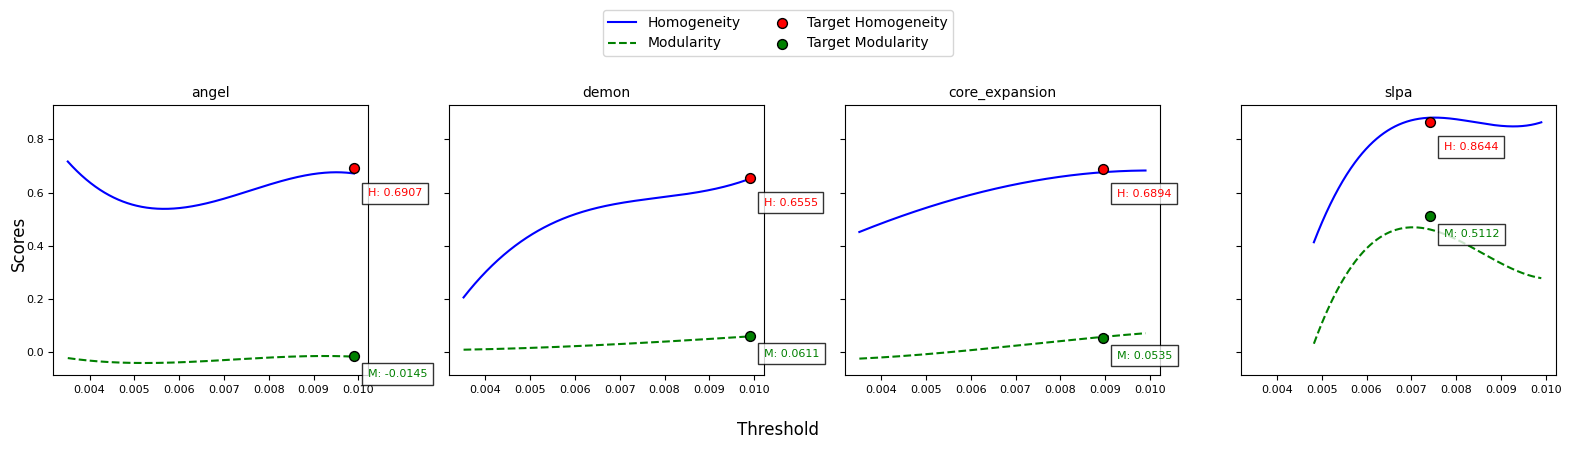

In [55]:
def plot_compact(data, algorithms, target_threshold=[]):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4), sharex=True, sharey=True)
    axes = axes.flatten()

    for idx, algo in enumerate(algorithms):
        if idx >= len(axes):  
            break

        thresholds = np.array(list(data[algo].keys()))
        homogeneities = np.array([data[algo][threshold]['mean_homogeneity'] for threshold in thresholds])
        modularities = np.array([data[algo][threshold]['modularity'].score for threshold in thresholds])

        f1 = np.array([data[algo][threshold]['f1'] for threshold in thresholds])
        nmi = np.array([data[algo][threshold]['nmi'] for threshold in thresholds])
        ari = np.array([data[algo][threshold]['ari'] for threshold in thresholds])

        sorted_indices = np.argsort(thresholds)
        thresholds, homogeneities, modularities = thresholds[sorted_indices], homogeneities[sorted_indices], modularities[sorted_indices]

        smooth_thresholds = np.linspace(thresholds.min(), thresholds.max(), 500)
        p_homogeneity = np.poly1d(np.polyfit(thresholds, homogeneities, 3))
        p_modularity = np.poly1d(np.polyfit(thresholds, modularities, 3))

        axes[idx].plot(smooth_thresholds, p_homogeneity(smooth_thresholds), 'b-', label='Homogeneity')
        axes[idx].plot(smooth_thresholds, p_modularity(smooth_thresholds), 'g--', label='Modularity')
        
        # print(idx)
        if idx < len(target_threshold) and target_threshold[idx] in thresholds:
            tgt = target_threshold[idx]
            target_index = np.where(thresholds == tgt)[0][0]
            target_homogeneity = homogeneities[target_index]
            target_modularity = modularities[target_index]

            axes[idx].scatter(tgt, target_homogeneity, color='red', edgecolor='black', zorder=5, label="Target Homogeneity", s=50)
            axes[idx].scatter(tgt, target_modularity, color='green', edgecolor='black', zorder=5, label="Target Modularity", s=50)

            # Dynamic Annotation Placement
            y_min, y_max = axes[idx].get_ylim()
            title_height = y_max - (y_max - y_min) * 0.15  # 15% below the top

            homogeneity_offset = 10 if target_homogeneity < title_height else -20
            modularity_offset = -15 if target_modularity < title_height else -30

            axes[idx].annotate(f'H: {target_homogeneity:.4f}', (tgt, target_homogeneity),
                               textcoords="offset points", xytext=(10, homogeneity_offset), fontsize=8,
                               ha='left', color='red', bbox=dict(facecolor='white', alpha=0.8))
            
            axes[idx].annotate(f'M: {target_modularity:.4f}', (tgt, target_modularity),
                               textcoords="offset points", xytext=(10, modularity_offset), fontsize=8,
                               ha='left', color='green', bbox=dict(facecolor='white', alpha=0.8))
            
        axes[idx].set_title(algo, fontsize=10)
        axes[idx].tick_params(axis='both', which='major', labelsize=8)

    fig.supxlabel("Threshold", fontsize=12)
    fig.supylabel("Scores", fontsize=12)

    handles, labels = axes[0].get_legend_handles_labels()
    
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2, fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()


plot_compact(ocd_metrics, algos, 
             target_threshold=[0.0098998998998999, 0.0098998998998999, 0.008948948948948949, 0.007417417417417417])


In [ ]:
base_path = "./overlapping_communities"
sizes = {}

thresholds = [0.008948948948948949, 0.0098998998998999, 0.0098998998998999, 
              0.009219219219219218, 0.00965965965965966, 0.0098998998998999, 
              0.0098998998998999, 0.00965965965965966]

for alg, thr in zip(algorithms_list, thresholds):
    with open(f"{base_path}/{alg}_{thr}communities.json", 'r') as f:
        data = json.load(f)

    total_nodes = sum(len(c) for c in data.values())  # Total nodes in valid communities
    num_communities = len(data)  # Number of valid communities

    if num_communities > 0:
        avg_size = total_nodes / num_communities
    else:
        avg_size = 0

    sizes[alg] = avg_size

    print(f"Algorithm: {alg}, Threshold: {thr}, Num Communities (Filtered): {num_communities}, Avg Community Size: {avg_size:.2f}")